In [ ]:
import os, sys

# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Change directory to project root
project_path = "/content/drive/MyDrive/medical-image-cnn"
%cd $project_path

# 3. Add project root to Python path
if project_path not in sys.path:
    sys.path.append(project_path)

# 4. Ensure __init__.py files exist in src/ packages
folders = [
    "src",
    "src/classification",
    "src/segmentation",
    "src/detection"
]
for folder in folders:
    init_file = os.path.join(folder, "__init__.py")
    if not os.path.exists(init_file):
        with open(init_file, "w") as f:
            f.write("# init\n")
        print(f"Created: {init_file}")

# 5. Check structure
print("SRC contents:", os.listdir(os.path.join(project_path, "src")))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/medical-image-cnn
SRC contents: ['classification', 'segmentation', 'detection', 'utils.py', '__init__.py', '__pycache__']


In [ ]:
!pip install tensorflow keras matplotlib seaborn scikit-learn opencv-python


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from src.classification.model_builder import build_mobilenet_classifier
from src.utils import plot_training

# Auto Split Data (80/20)
data_dir = "/content/drive/MyDrive/medical-image-cnn/datasets/brain_mri"
img_size = (128,128)
batch_size = 16

# ✅ Create data generators with validation_split + augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,       # <-- fixed comma here
    rotation_range=20,          # randomly rotate images (0–20 degrees)
    width_shift_range=0.1,      # randomly shift image width
    height_shift_range=0.1,     # randomly shift image height
    shear_range=0.1,            # shear transformations
    zoom_range=0.1,             # zoom in/out
    horizontal_flip=True,       # flip images horizontally
    fill_mode='nearest'         # fill pixels after rotation/shift
)

# Training generator (80%)
train_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,
    seed=42
)

# Testing generator (20%)
test_gen = datagen.flow_from_directory(
    data_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False,
    seed=42
)

num_classes = len(train_gen.class_indices)
class_labels = list(train_gen.class_indices.keys())
print(f"\nDetected classes ({num_classes}): {class_labels}")


Found 17339 images belonging to 4 classes.
Found 4333 images belonging to 4 classes.

Detected classes (4): ['glioma_tumor', 'meningioma_tumor', 'normal', 'pituitary_tumor']


In [ ]:
model = build_mobilenet_classifier(input_shape=(128,128,3), num_classes=num_classes)
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 141s 707ms/step - accuracy: 0.6182 - loss: 0.9556 - val_accuracy: 0.7725 - val_loss: 0.5490
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 103s 519ms/step - accuracy: 0.7403 - loss: 0.6549 - val_accuracy: 0.8737 - val_loss: 0.3597
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 101s 508ms/step - accuracy: 0.7674 - loss: 0.5828 - val_accuracy: 0.8388 - val_loss: 0.4238
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 84s 421ms/step - accuracy: 0.7710 - loss: 0.5737 - val_accuracy: 0.8888 - val_loss: 0.3560
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 76s 380ms/step - accuracy: 0.7958 - loss: 0.5431 - val_accuracy: 0.8050 - val_loss: 0.4628
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 29s 144ms/step - accuracy: 0.7860 - loss: 0.5071 - val_accuracy: 0.8662 - val_loss: 0.3322
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 61s 305ms/step - accuracy: 0.8153 - loss: 0.4920 - val_accuracy: 0.8687 - val_loss: 0.3369
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 57s 289ms/step - accuracy: 0.8182 - loss

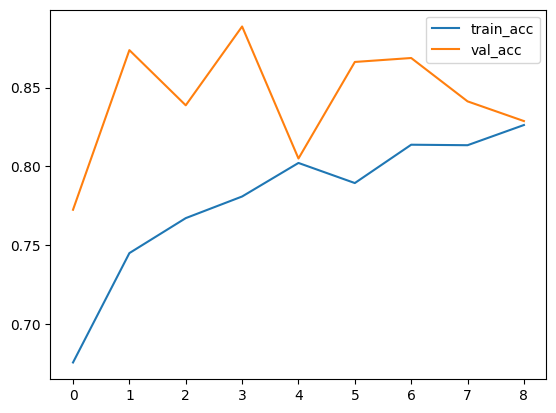

In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Ensure checkpoint folder exists
os.makedirs("outputs/checkpoints", exist_ok=True)

# Save best model automatically
checkpoint = ModelCheckpoint(
    "outputs/checkpoints/best_brain_mri.keras",  # modern format
    save_best_only=True,
    monitor="val_loss",
    mode="min"
)

# Stop early if no improvement
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,  # stop if validation loss doesn't improve for 3 epochs
    restore_best_weights=True
)

# Train the Model
history = model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,               # you can increase later
    steps_per_epoch=200,     # limit per epoch for faster runs
    validation_steps=50,
    callbacks=[checkpoint, early_stop]
)

# Plot Training Results
plot_training(history)
